# Deteccão de COVID-19 em imagens de raio-X

O objetivo deste exercício é treinar e avaliar um classificador capaz de detectar a presença de COVID-19 em imagens de raio-X.

As métricas a serem reportadas são F1 e Equal Error Rate (ERR) e seu respectivo threshold.

Nota 1: uma das dificuldades deste exercicio será processar as imagens, que tem 1100 x 1100 pixels.

Nota 2: Não podemos utilizar outros datasets de COVID para treinamento, pois o nosso dataset foi construído a partir de vários outros disponíveis na internet. Mas podemos usar outros datasets que não são de COVID para ajudar no transfer learning.

Dica: Utilize o [pyeer](https://pypi.org/project/pyeer/) para plotar o EER.


## Inicializando o Neptune

In [ ]:
! pip install neptune-client==0.9.1

     |████████████████████████████████| 215kB 35.8MB/s 
     |████████████████████████████████| 829kB 46.2MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 163kB 51.8MB/s 
     |████████████████████████████████| 133kB 52.9MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.9.1-py2.py3-none-any.whl size=371716 sha256=7338473fb9f5f878f52ad403b47a5ded0afd451342996fc537d76f337ddb7d91
  Stored in directory: /root/.cache/pip/wheels/6e/d4/60/21005f18273566da0463587bed8c69cce7f300a404edf26df8
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=d2b2d06450e4a31852ce94e4a6eb689e87c990a58608f2346ca384ac826a8db7
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-

In [ ]:
import neptune.new as neptune

# Insira seu api_token para logar os resultados do treino na sua conta do Neptune.
# Como obter seu API token do Neptune:
# https://docs.neptune.ai/administration/security-and-privacy/how-to-find-and-set-neptune-api-token

# run = neptune.init(project='d230640/Aula7', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmZTg1OGU3Yi1jOWE1LTRjMjEtYTJjNS1hMjMwM2Y3NDRjOTUifQ==')

## Importação das bibliotecas

In [ ]:
!pip install pytorch_lightning==1.2.10

     |████████████████████████████████| 849kB 33.5MB/s 
     |████████████████████████████████| 276kB 42.8MB/s 
     |████████████████████████████████| 112kB 50.8MB/s 
     |████████████████████████████████| 184kB 51.8MB/s 
     |████████████████████████████████| 1.3MB 39.8MB/s 
     |████████████████████████████████| 296kB 52.3MB/s 
     |████████████████████████████████| 143kB 55.1MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=7572861742fa143772ffaba5d0be469af27175dcaf22b168e14e08c072f65886
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import cv2
from collections import OrderedDict
import h5py
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch import nn

import torchvision
from torchvision import transforms

import pytorch_lightning
from pytorch_lightning import LightningModule, Trainer
from PIL import Image

pytorch_lightning.utilities.seed.seed_everything(seed=123)

Global seed set to 123


123

## Dataset e dataloader

### Carregamento, criação dataset e do dataloader

In [ ]:
# O download demora.
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/* .

Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/test.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/train.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/valid.hdf5...
\ [3/3 files][ 11.3 GiB/ 11.3 GiB] 100% Done  31.0 MiB/s ETA 00:00:00           
Operation completed over 3 objects/11.3 GiB.                                     


In [ ]:
size_final = (224, 224)

path = 'train'
path_dir = './' + path +'.hdf5'
h5file = h5py.File(path_dir, 'r')
imagem = h5file['data'][3]
imagem = ((imagem/np.max(imagem))*255).astype(np.uint8)
imagem = cv2.resize( imagem ,size_final,interpolation=cv2.INTER_CUBIC)
np.save('image_teste', imagem) 


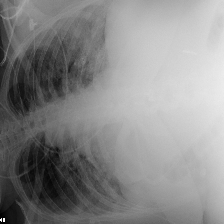

In [ ]:
image_load_test = np.load('image_teste.npy')
transforms.ToPILImage()(image_load_test)

In [ ]:
paths = ['train','valid','test']
for path in paths:
  !mkdir $path
  %cd $path
  !mkdir 0
  !mkdir 1
  %cd ..
  !pwd

/content/train
/content
/content
/content/valid
/content
/content
/content/test
/content
/content


In [ ]:
paths = ['train','valid','test']
for path in paths:
  path_dir = './' + path +'.hdf5'
  h5file = h5py.File(path_dir, 'r')
  for i in range(len(h5file['data'])):
      imagem = h5file['data'][i]
      imagem = ((imagem/np.max(imagem))*255).astype(np.uint8) #Dica do colega Orlem para normalizaçãão dos dados
      imagem = cv2.resize( imagem ,size_final,interpolation=cv2.INTER_CUBIC)
      im = Image.fromarray(imagem)
      im.save(path+'/'+str(h5file['label'][i])+'/imagem'+str(i)+'.jpg')

In [ ]:
!rm test.hdf5 train.hdf5 valid.hdf5

Aqui criamos um dataset sem aumento de dados

In [ ]:
size_final = (224, 224)

transform_train = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=size_final)])

transform_valid = transform_train

In [ ]:
rootdir = '/content'
train_dataset = torchvision.datasets.ImageFolder(
    rootdir + '/train/', transform=transform_train)

val_dataset = torchvision.datasets.ImageFolder(
    rootdir + '/valid/', transform=transform_valid)

test_dataset = torchvision.datasets.ImageFolder(
    rootdir + '/test/', transform=transform_valid)

In [ ]:
# class Hdf5_Dataset(torch.utils.data.Dataset):

#     def __init__(self, path, transform):

#         h5file = h5py.File(path, 'r')
#         # Hack para deixar mais rapido o carregamento das imagens.
#         self.images = h5file['data'][:1000]
#         self.labels = h5file['label'][:1000]
#         self.transform = transform

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         label = self.labels[idx].astype(np.int64)
#         img = self.images[idx].astype(np.uint8)
#         img = self.transform(img)
#         img = img.tile(3, 1, 1)
      
#         return img, label

In [ ]:
# train_dataset = Hdf5_Dataset('./train.hdf5', transform=transform_train)
# val_dataset = Hdf5_Dataset('./valid.hdf5', transform=transform_valid)
# test_dataset = Hdf5_Dataset('./test.hdf5', transform=transform_valid)

In [ ]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 60
Número de minibatches de validação: 20
Número de minibatches de teste: 20

Dimensões dos dados de um minibatch: torch.Size([50, 3, 224, 224])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


In [ ]:
class MyLightningModule(LightningModule):
    def __init__(self, hparams, run):
        super().__init__()

        print(hparams)
        self.hparams = hparams
        run['hparams'] = hparams  # Log to Neptune.
        self.criterion = nn.CrossEntropyLoss(reduction='none')

        # Carregando um modelo baseado na MobileNet V3.
        self.model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=hparams['pretrained'])
        # Modificando a ultima camada de classificação para 2 classes.
        self.model.fc.out_features=2

    def forward(self, x):
        logits = self.model(x)
        preds = logits.argmax(dim=1)
        return logits, preds

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch

        # predict da rede
        logits = self.model(x)

        # calcula a perda
        batch_losses = self.criterion(logits, y)
        loss = batch_losses.mean()
        run['train/batch_loss'].log(loss)

        # O PL sempre espera um retorno nomeado 'loss' da training_step.
        return {'loss': loss, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['train/loss'].log(avg_loss)
        return
  
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        
        # predict da rede
        logits, preds = self.forward(x)

        # calcula a perda
        batch_losses = self.criterion(logits, y)
        # calcula a acurácia
        batch_accuracy = (preds == y)
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.stack([output['batch_accuracy'] for output in outputs]).float().mean()

        run['valid/loss'].log(avg_loss)
        run['valid/acuracy'].log(accuracy)

        self.log('valid_loss', avg_loss.item(), prog_bar=True)
        self.log('valid_accuracy', accuracy.item(), prog_bar=True)
  
    def test_step(self, val_batch, batch_idx):
        # A implementação deste método é opcional no Pytorch Lightning.
        x, y = val_batch
        
        # predict da rede
        logits, preds = self.forward(x)

        # calcula a perda
        batch_losses = self.criterion(logits, y)
        # calcula a acurácia
        batch_accuracy = (preds == y)
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy}

    def test_epoch_end(self, outputs):
        # A implementação deste método é opcional no Pytorch Lightning.
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.stack([output['batch_accuracy'] for output in outputs]).float().mean()

        run['valid/loss'].log(avg_loss)
        run['valid/acuracy'].log(accuracy)

        self.log('test_loss', avg_loss.item())
        self.log('test_accuracy', accuracy.item())

    def configure_optimizers(self):
        # Gradiente descendente
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams['learning_rate'])
        # Aqui usamos um scheduler dummy pois o pytorch lightning original requer um.
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 1.0)
        return [optimizer], [scheduler]  # Forma de retorno para associar um otimizador a um scheduler.

# Sem Aumentação de Dados

In [ ]:
hparams = {
    'max_epochs': 100,
    'learning_rate': 3e-4,
    'pretrained': True,
    'augmentation': False
}

run = neptune.init(project='d230640/Aula7', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmZTg1OGU3Yi1jOWE1LTRjMjEtYTJjNS1hMjMwM2Y3NDRjOTUifQ==')
run["sys/tags"].add([f'pre:{hparams["pretrained"]}', f'aug:{hparams["augmentation"]}'])

pl_model = MyLightningModule(hparams=hparams, run=run)
trainer = Trainer(max_epochs=hparams['max_epochs'], gpus=1,num_sanity_val_steps=0)
trainer.fit(pl_model, train_dataloader, val_dataloader)

https://app.neptune.ai/d230640/Aula7/e/AUL2-10
{'max_epochs': 100, 'learning_rate': 0.0003, 'pretrained': True, 'augmentation': False}


Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 25.6 M
-----------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.228   Total estimated model params size (MB)


Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 603, in _update_chunk_length
    self.chunk_left = int(line, 16)
ValueError: invalid literal for int() with base 16: b''

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 362, in _error_catcher
    yield
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 668, in read_chunked
    self._update_chunk_length()
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 607, in _update_chunk_length
    raise httplib.IncompleteRead(line)
http.client.IncompleteRead: IncompleteRead(0 bytes read)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/requests/models.py", line 751, in generate
    fo

Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: train/batch_loss. Invalid point: 2021-05-12T22:42:16.592Z
Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: train/batch_loss. Invalid point: 2021-05-12T22:42:17.217Z
Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: train/batch_loss. Invalid point: 2021-05-12T22:42:17.825Z
Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: train/batch_loss. Invalid point: 2021-05-12T22:42:18.441Z
Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: train/batch_loss. Invalid point: 2021-05-12T22:42:19.057Z
Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: train/batch_loss. Invalid point: 2021-

1

In [ ]:
trainer.test(pl_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9580000638961792, 'test_loss': 0.18530778586864471}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.9580000638961792, 'test_loss': 0.18530778586864471}]

#Com Aumentação de Dados

In [ ]:
size_large = (256, 256)
size_final = (224, 224)

transform_train = transforms.Compose([
    transforms.Resize(size=size_large),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(3, translate=None, scale=(0.95, 1.05), shear=None, resample=False, fillcolor=2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=size_final),
    transforms.ToTensor()])

# Não funciona se fizermos train_dataloader.dataset.transform, portanto temos que recriar o Dataset e Dataloader.
train_dataset = torchvision.datasets.ImageFolder(
    rootdir + '/train/', transform=transform_train)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1315: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1329: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


In [ ]:
hparams = {
    'max_epochs': 100,
    'learning_rate': 3e-4,
    'pretrained': True,
    'augmentation': True
}
run = neptune.init(project='d230640/Aula7', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmZTg1OGU3Yi1jOWE1LTRjMjEtYTJjNS1hMjMwM2Y3NDRjOTUifQ==')
run["sys/tags"].add([f'pre:{hparams["pretrained"]}', f'aug:{hparams["augmentation"]}'])

pl_model = MyLightningModule(hparams=hparams, run=run)
trainer = Trainer(max_epochs=hparams['max_epochs'], gpus=1,num_sanity_val_steps=0)
trainer.fit(pl_model, train_dataloader, val_dataloader)

https://app.neptune.ai/d230640/Aula7/e/AUL2-11
{'max_epochs': 100, 'learning_rate': 0.0003, 'pretrained': True, 'augmentation': True}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 25.6 M
-----------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.228   Total estimated model params size (MB)


1

In [ ]:
trainer.test(pl_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9490000605583191, 'test_loss': 0.21719573438167572}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.9490000605583191, 'test_loss': 0.21719573438167572}]

# Verificação das métricas F1 e Equal Error Rate (ERR)

In [ ]:
!pip install pyeer==0.4.9

     |████████████████████████████████| 593kB 30.9MB/s 


Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated


  Created wheel for pyeer: filename=pyeer-0.4.9-cp37-none-any.whl size=598665 sha256=7b7e9cbe1255e1d49464b3e906ca36b3ae2b10efd90d35ef5e3b454f432e4dda
  Stored in directory: /root/.cache/pip/wheels/e8/c2/11/91b95fc5263b5ec6f66f0859a56315d1dc4344d226f34407b3
Successfully built pyeer


In [ ]:
from sklearn.metrics import f1_score
from pyeer.eer_info import get_eer_stats
from pyeer.reports import generate_eer_report, plot_eer_stats

import matplotlib.pyplot as plt

In [ ]:
def verify(pl_model,dataloader):
  pl_model.model.eval()
  y_pred_total = []
  y_true_total = []
  newlist = []
  for x,y in iter(dataloader):
    x, y = x.cuda(), y.cuda()
    with torch.no_grad():
      logit = pl_model.model(x)
      y_pred = torch.argmax(logit,dim=1)
    y_true_total = np.append(y_true_total,np.array(y.cpu()))
    y_pred_total = np.append(y_pred_total,np.array(y_pred.cpu()))

    # y_true_total.append(np.array(y.cpu()))
    # y_pred_total.append(np.array(y_pred.cpu()))
  
  print(len(y_true_total))
  print(len(y_pred_total))

  print(f1_score(y_true_total, y_pred_total, average='macro'))
  print(f1_score(y_true_total, y_pred_total, average='micro'))

  stats = get_eer_stats(y_true_total, y_pred_total)

  plot_eer_stats([stats], ['test'])

3000
3000
0.9927771104566689
0.993


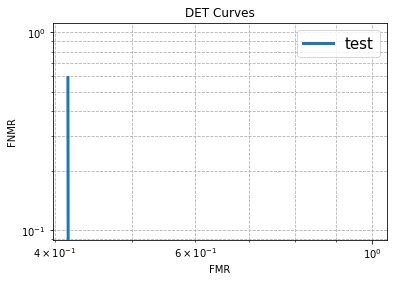

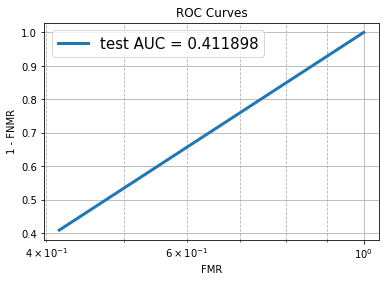

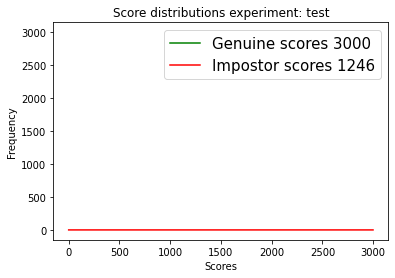

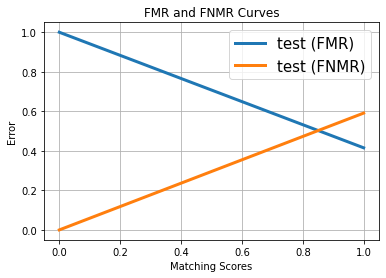

In [ ]:
verify(pl_model,train_dataloader)

1000
1000
0.9633691582965194
0.965


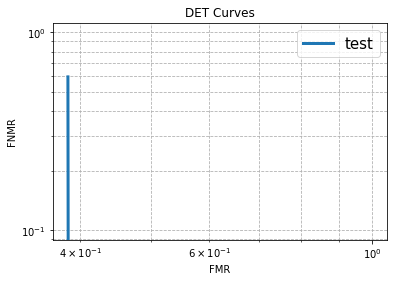

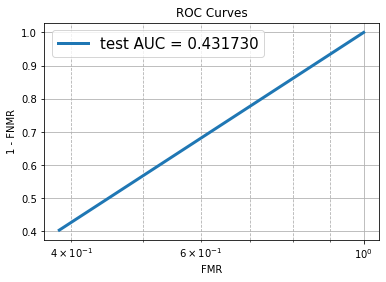

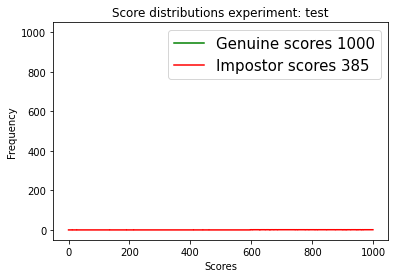

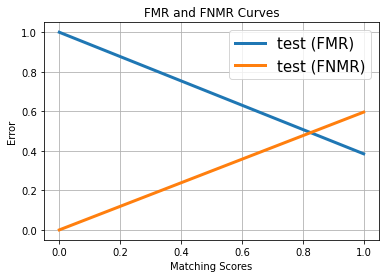

In [ ]:
verify(pl_model,val_dataloader)

1000
1000
0.9478736006361466
0.949


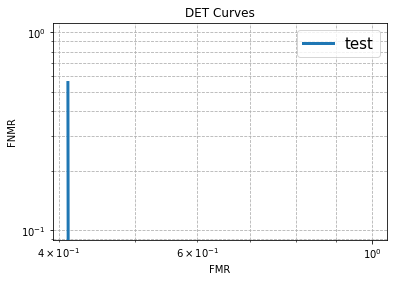

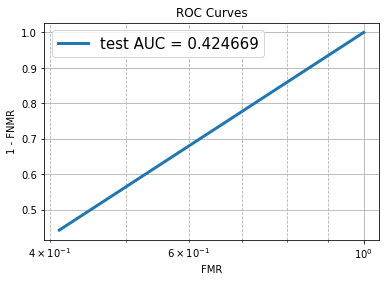

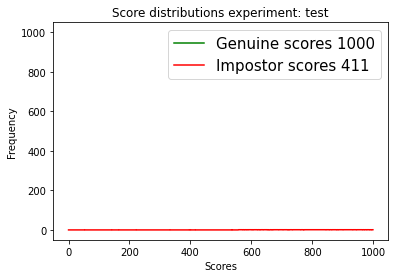

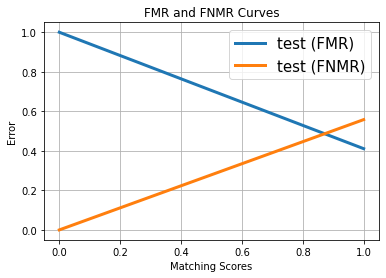

In [ ]:
verify(pl_model,test_dataloader)